In [1]:
from os import listdir
from os.path import isfile, join
from pprint import pprint
from collections import Counter
from sklearn.metrics.pairwise import cosine_distances, euclidean_distances
from sklearn.metrics import accuracy_score, mean_squared_error
import matplotlib.pyplot as plt
import numpy as np
import random
import os

In [2]:
# creates absolute path
def abspath(path, *paths):
    fpath = os.path.join(os.getcwd(), os.pardir, path)

    for p in paths:
        fpath = os.path.join(fpath, p)
    return fpath

In [3]:
train_directory = abspath('datasets', 'ml-100k')
train_file_locations = [train_directory + '\\' + f for f in listdir(train_directory) if isfile(join(train_directory, f)) and f not in ['annotations.txt', 'notes.txt']]

def retrieve_file_contents(filename, delimiter=' '):
    data = []
    with open(train_directory + r'\\' + filename) as f:
        for line in f.readlines():
            line = line.replace('\n', ' ').replace('\t', ' ').strip().split(delimiter)
            if '' in line:
                line.remove('')  # Only remove first occurence of '' that occurs in the list
            data.append(line)
    return data
    
u_data = np.array(retrieve_file_contents('u.data'))
u_user = np.array(retrieve_file_contents('u.user', delimiter='|'))
ua_base = np.array(retrieve_file_contents('ua.base'))
ua_test = np.array(retrieve_file_contents('ua.test'))
ub_base = np.array(retrieve_file_contents('ub.base'))
ub_test = np.array(retrieve_file_contents('ub.test'))
u_item = np.array(retrieve_file_contents('u.item', delimiter='|'))

print(u_data.shape)
print(u_user.shape)
print(ua_base.shape)
print(ua_test.shape)
print(ub_base.shape)
print(ub_test.shape)
print(u_item.shape)

(100000, 4)
(943, 5)
(90570, 4)
(9430, 4)
(90570, 4)
(9430, 4)
(1682, 23)


In [4]:
def get_ratings_matrix(u_data):
    ratings_matrix = u_data[:, [0,1,2]]
    return ratings_matrix

ratings_matrix = get_ratings_matrix(u_data)

In [5]:
def get_utility_matrix(u_data):
    utility_matrix = np.zeros((u_user.shape[0], u_item.shape[0]))
    for data in u_data:
        utility_matrix[int(data[0]) - 1][int(data[1]) - 1] = data[2]
    return utility_matrix

utility_matrix = get_utility_matrix(u_data)

In [6]:
def get_user_sim_matrix(utility_matrix, distance_metric='e'):
    user_sim_matrix = np.zeros((u_user.shape[0], u_user.shape[0]))
    for i in range(u_user.shape[0]):
        for j in range(u_user.shape[0]):
            if distance_metric == 'e':
                user_sim_matrix[i][j] = euclidean_distances([utility_matrix[i]], [utility_matrix[j]]) 
            elif distance_metric == 'c':
                user_sim_matrix[i][j] = cosine_distances([utility_matrix[i]], [utility_matrix[j]]) 
    return user_sim_matrix

euclidean_user_sim_matrix = get_user_sim_matrix(utility_matrix, distance_metric='e')
cosine_user_sim_matrix = get_user_sim_matrix(utility_matrix, distance_metric='c')

In [7]:
def get_row_idx(total_size, test_size=100):

    # Sample out 'TEST_SIZE' number of indices
    row_idx = np.zeros((test_size))
    i = 0
    while i < test_size:
        r = random.randrange(0, total_size)
        if r not in row_idx:
            row_idx[i] = r
            i += 1
    row_idx = row_idx.astype(int)

    return row_idx

row_idx = get_row_idx(u_data.shape[0], test_size=100)
test_data = u_data[row_idx[:, None], [0,1]]
test_labels = u_data[row_idx[:, None], [2]]
test_labels = test_labels.astype(np.int)

In [8]:
def knn(K, distance_matrix, utility_matrix, test_data, test_labels):

    predicted_labels = []       # List of predicted labels for test set 
    for data in test_data:
        
        i = int(data[0]) - 1
        movie_id = int(data[1]) - 1
        
        # Store indices of sorted neighbors
        neighbors = np.argsort(distance_matrix[i])
        neighbors = np.delete(neighbors, np.argwhere(neighbors == i))

        # Store labels of k nearest neighbors
        weighted_avg = 0
        den = 0
        for j in range(K):
            if utility_matrix[neighbors[j]][movie_id] != 0.0:
                weighted_avg += utility_matrix[neighbors[j]][movie_id] * distance_matrix[i][neighbors[j]]
                den += distance_matrix[i][neighbors[j]]
        weighted_avg = weighted_avg / den if int(den) != 0 else 0.0    
        predicted_labels.append([int(weighted_avg)])
    predicted_labels = np.asarray(predicted_labels)
    
    return predicted_labels

In [9]:
def get_rmse(predicted_labels, test_labels):
    rmse = mean_squared_error(predicted_labels, test_labels) ** 0.5
    return rmse

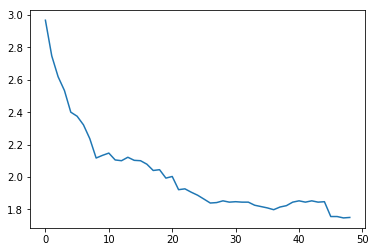

1.7578395831246945


In [10]:
# Without normalizing, euclidean distances
rmse = []
for i in range(1, 50):
    rmse.append(get_rmse(knn(i, euclidean_user_sim_matrix, utility_matrix, test_data, test_labels), test_labels))

plt.plot(rmse)
plt.show()

print(get_rmse(knn(50, euclidean_user_sim_matrix, utility_matrix, test_data, test_labels), test_labels))

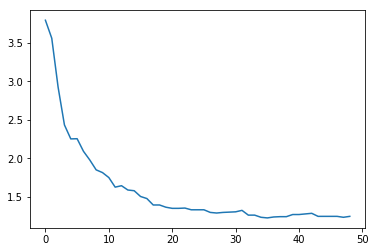

1.2409673645990857


In [11]:
# Without normalizing, cosine distances
rmse = []
for i in range(1, 50):
    rmse.append(get_rmse(knn(i, cosine_user_sim_matrix, utility_matrix, test_data, test_labels), test_labels))

plt.plot(rmse)
plt.show()

print(get_rmse(knn(50, cosine_user_sim_matrix, utility_matrix, test_data, test_labels), test_labels))